# Sample code of Image Classification VGG16 Model with PyTorch

This notebook is the sample code of training the image classification model using COCO2014 dataset.  
COCO2014 dataset has not classification labels, therefore it makes classification dataset cropping bounding boxes.

|Item|Description|
|---|---|
|DeepLearning Framework|PyTorch|
|Dataset|COCO2014 Classification|
|Model Architecture|VGG16|

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
#import cv2
#import json
#import numpy as np
#import pandas as pd
#from pathlib import Path
from tqdm import tqdm
#from PIL import Image
#from data_loader.data_loader import DataLoader
#from models.pytorch import vgg16
import itertools
#
#import torch
#from torch.utils.data import Dataset

import random
import pandas as pd
import numpy as np
import torch
import pprint

from data_loader.data_loader import DataLoader
from models.pytorch import vgg16

## Set Random Seed

In [3]:
seed=42

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

## Device Settings

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

## Hyperparameters

In [5]:
epochs = 3
batch_size = 32
learning_rate = 0.0001
weight_decay = 0.001
input_tensor_shape = (3, 224, 224)   # CHW

## Preparing Dataset

### Download and Extract

In [6]:
dataset_dir = '/tmp/dataset'
os.makedirs(dataset_dir, exist_ok=True)
dataloader = DataLoader(dataset_name='coco2014_classification_pytorch', resize=input_tensor_shape[1:], dataset_dir=dataset_dir, batch_size=batch_size)

100% 300000/300000 [52:19<00:00, 95.56it/s]  
100% 84509/84509 [01:04<00:00, 1317.60it/s]
100% 84509/84509 [00:00<00:00, 636579.61it/s]
100% 291875/291875 [29:36<00:00, 164.27it/s] 
100% 56834/56834 [00:45<00:00, 1237.10it/s]
100% 56834/56834 [00:00<00:00, 643566.80it/s]


In [7]:
dataloader.dataset.class_name

['hot dog',
 'dog',
 'potted plant',
 'tv',
 'bird',
 'cat',
 'horse',
 'sheep',
 'cow',
 'bottle',
 'couch',
 'chair',
 'dining table',
 'bicycle',
 'car',
 'motorcycle',
 'airplane',
 'bus',
 'train',
 'boat',
 'person',
 'stop sign',
 'umbrella',
 'tie',
 'sports ball',
 'sandwich',
 'bed',
 'cell phone',
 'refrigerator',
 'clock',
 'toothbrush',
 'truck',
 'traffic light',
 'fire hydrant',
 'parking meter',
 'bench',
 'elephant',
 'bear',
 'zebra',
 'giraffe',
 'frisbee',
 'skis',
 'snowboard',
 'kite',
 'baseball bat',
 'baseball glove',
 'skateboard',
 'surfboard',
 'tennis racket',
 'wine glass',
 'cup',
 'fork',
 'knife',
 'spoon',
 'bowl',
 'banana',
 'apple',
 'orange',
 'broccoli',
 'carrot',
 'pizza',
 'donut',
 'cake',
 'toilet',
 'laptop',
 'mouse',
 'remote',
 'keyboard',
 'microwave',
 'oven',
 'toaster',
 'sink',
 'book',
 'vase',
 'scissors',
 'teddy bear',
 'hair drier',
 'backpack',
 'handbag',
 'suitcase']

In [8]:
trainloader = dataloader.dataset.trainloader

In [9]:
train_labels = []
i = 0
for inputs, labels in tqdm(trainloader):
    train_labels += labels.tolist()
train_labels

100% 2641/2641 [38:59<00:00,  1.13it/s]


[0,
 5,
 87,
 3,
 0,
 18,
 0,
 20,
 0,
 81,
 4,
 66,
 2,
 87,
 4,
 43,
 51,
 7,
 10,
 53,
 0,
 0,
 0,
 0,
 81,
 5,
 0,
 0,
 4,
 6,
 0,
 43,
 0,
 51,
 14,
 23,
 0,
 71,
 4,
 1,
 18,
 40,
 23,
 80,
 66,
 23,
 0,
 63,
 0,
 0,
 50,
 8,
 0,
 33,
 0,
 18,
 0,
 0,
 69,
 5,
 0,
 78,
 23,
 0,
 2,
 55,
 0,
 0,
 5,
 0,
 0,
 0,
 7,
 0,
 0,
 24,
 64,
 62,
 0,
 0,
 32,
 3,
 6,
 72,
 0,
 4,
 69,
 0,
 61,
 63,
 0,
 31,
 23,
 16,
 85,
 2,
 58,
 0,
 18,
 16,
 0,
 48,
 0,
 0,
 0,
 0,
 18,
 0,
 0,
 59,
 0,
 45,
 0,
 0,
 23,
 0,
 47,
 58,
 0,
 43,
 6,
 0,
 0,
 66,
 0,
 0,
 48,
 30,
 0,
 31,
 57,
 51,
 0,
 78,
 16,
 51,
 16,
 9,
 18,
 62,
 64,
 0,
 0,
 24,
 46,
 58,
 0,
 49,
 0,
 17,
 21,
 0,
 31,
 0,
 0,
 24,
 60,
 0,
 38,
 51,
 22,
 5,
 0,
 10,
 20,
 0,
 6,
 32,
 58,
 0,
 66,
 0,
 17,
 17,
 16,
 0,
 85,
 0,
 71,
 53,
 66,
 0,
 0,
 13,
 81,
 0,
 0,
 3,
 4,
 13,
 0,
 56,
 0,
 17,
 41,
 56,
 64,
 30,
 0,
 6,
 81,
 56,
 66,
 51,
 0,
 61,
 8,
 0,
 8,
 23,
 76,
 8,
 0,
 66,
 87,
 16,
 72,
 62,
 85,
 66,
 0,
 0,

<Axes: ylabel='Frequency'>

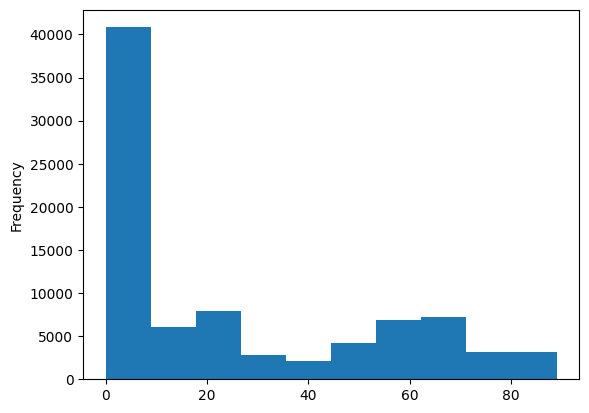

In [10]:
pd.Series(np.array(train_labels, dtype=int)).plot.hist()

In [11]:
pd.Series(np.array(train_labels, dtype=int)).unique()

array([ 0,  5, 87,  3, 18, 20, 81,  4, 66,  2, 43, 51,  7, 10, 53,  6, 14,
       23, 71,  1, 40, 80, 63, 50,  8, 33, 69, 78, 55, 24, 64, 62, 32, 72,
       61, 31, 16, 85, 58, 48, 59, 45, 47, 30, 57,  9, 46, 49, 17, 21, 60,
       38, 22, 13, 56, 41, 76, 27, 73, 34, 15, 19, 54, 39, 86, 83, 26, 35,
       42, 12, 37, 52, 75, 89, 84, 74, 36, 77, 79, 88])

In [12]:
max(train_labels)

89

## Training VGG16

In [13]:
input_size = (batch_size, 3, 224, 224)
#num_classes = len(dataloader.dataset.class_name)
num_classes = max(train_labels)+1
model = vgg16.VGG16(device, input_size=input_size, num_classes=num_classes)

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [32, 90]                  --
├─Sequential: 1-1                        [32, 64, 224, 224]        --
│    └─Conv2d: 2-1                       [32, 64, 224, 224]        1,792
│    └─BatchNorm2d: 2-2                  [32, 64, 224, 224]        128
│    └─ReLU: 2-3                         [32, 64, 224, 224]        --
├─Sequential: 1-2                        [32, 64, 112, 112]        --
│    └─Conv2d: 2-4                       [32, 64, 224, 224]        36,928
│    └─BatchNorm2d: 2-5                  [32, 64, 224, 224]        128
│    └─ReLU: 2-6                         [32, 64, 224, 224]        --
│    └─MaxPool2d: 2-7                    [32, 64, 112, 112]        --
├─Sequential: 1-3                        [32, 128, 112, 112]       --
│    └─Conv2d: 2-8                       [32, 128, 112, 112]       73,856
│    └─BatchNorm2d: 2-9                  [32, 128, 112, 112]       256
│

In [14]:
model_dir = 'coco2014_clf'
model.train(dataloader.dataset.trainloader, epochs=epochs, lr=learning_rate, wd=weight_decay, output_dir=model_dir)

[EPOCH #0, step #0] loss: 5.011264801025391
[EPOCH #0, step #2] loss: 4.808112621307373
[EPOCH #0, step #4] loss: 4.779122734069825
[EPOCH #0, step #6] loss: 4.801761150360107
[EPOCH #0, step #8] loss: 4.745552115970188
[EPOCH #0, step #10] loss: 4.742481535131281
[EPOCH #0, step #12] loss: 4.743678459754357
[EPOCH #0, step #14] loss: 4.73467378616333
[EPOCH #0, step #16] loss: 4.747528889599969
[EPOCH #0, step #18] loss: 4.738131949776097
[EPOCH #0, step #20] loss: 4.74905032203311
[EPOCH #0, step #22] loss: 4.7384296085523525
[EPOCH #0, step #24] loss: 4.739431266784668
[EPOCH #0, step #26] loss: 4.74488549762302
[EPOCH #0, step #28] loss: 4.742120249518033
[EPOCH #0, step #30] loss: 4.739771981393138
[EPOCH #0, step #32] loss: 4.743175087553082
[EPOCH #0, step #34] loss: 4.739212935311453
[EPOCH #0, step #36] loss: 4.733048310150972
[EPOCH #0, step #38] loss: 4.733639729328645
[EPOCH #0, step #40] loss: 4.734997237600932
[EPOCH #0, step #42] loss: 4.733519620673601
[EPOCH #0, step #

## Test Model

In [15]:
train_result = model.predict(dataloader.dataset.trainloader)
train_predictions, train_labels = train_result

In [16]:
train_eval_result = model.evaluate(train_labels, train_predictions)
pprint.pprint(train_eval_result)

{'accuracy': 0.36412689772686935,
 'classification_report': {'0': {'f1-score': 0.5377104284840015,
                                 'precision': 0.36954174513496546,
                                 'recall': 0.9867578530959804,
                                 'support': 29829},
                           '1': {'f1-score': 0.0,
                                 'precision': 0.0,
                                 'recall': 0.0,
                                 'support': 566},
                           '10': {'f1-score': 0.0,
                                  'precision': 0.0,
                                  'recall': 0.0,
                                  'support': 376},
                           '12': {'f1-score': 0.0,
                                  'precision': 0.0,
                                  'recall': 0.0,
                                  'support': 239},
                           '13': {'f1-score': 0.0,
                                  'precision': 0.0,
           

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
test_result = model.predict(dataloader.dataset.testloader)
test_predictions, test_labels = test_result

In [18]:
test_eval_result = model.evaluate(test_labels, test_predictions)
pprint.pprint(test_eval_result)

{'accuracy': 0.3543477495865151,
 'classification_report': {'0': {'f1-score': 0.5314964294737962,
                                 'precision': 0.36518465727390675,
                                 'recall': 0.9759718695057629,
                                 'support': 20476},
                           '1': {'f1-score': 0.0,
                                 'precision': 0.0,
                                 'recall': 0.0,
                                 'support': 331},
                           '10': {'f1-score': 0.0,
                                  'precision': 0.0,
                                  'recall': 0.0,
                                  'support': 221},
                           '12': {'f1-score': 0.0,
                                  'precision': 0.0,
                                  'recall': 0.0,
                                  'support': 117},
                           '13': {'f1-score': 0.0,
                                  'precision': 0.0,
            

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
